In [44]:
from lightkurve import search_lightcurve, LightCurveCollection
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
%matplotlib inline

from lightkurve.correctors import CBVCorrector

In [87]:
lcs = search_lightcurve('KIC 8462852', cadence='long').download_all(flux_column='sap_flux')

cbvCorrector = []

[cbvCorrector.append(CBVCorrector(lcs[i])) for i in range(len(lcs))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [88]:
lc = lcs.stitch()

0


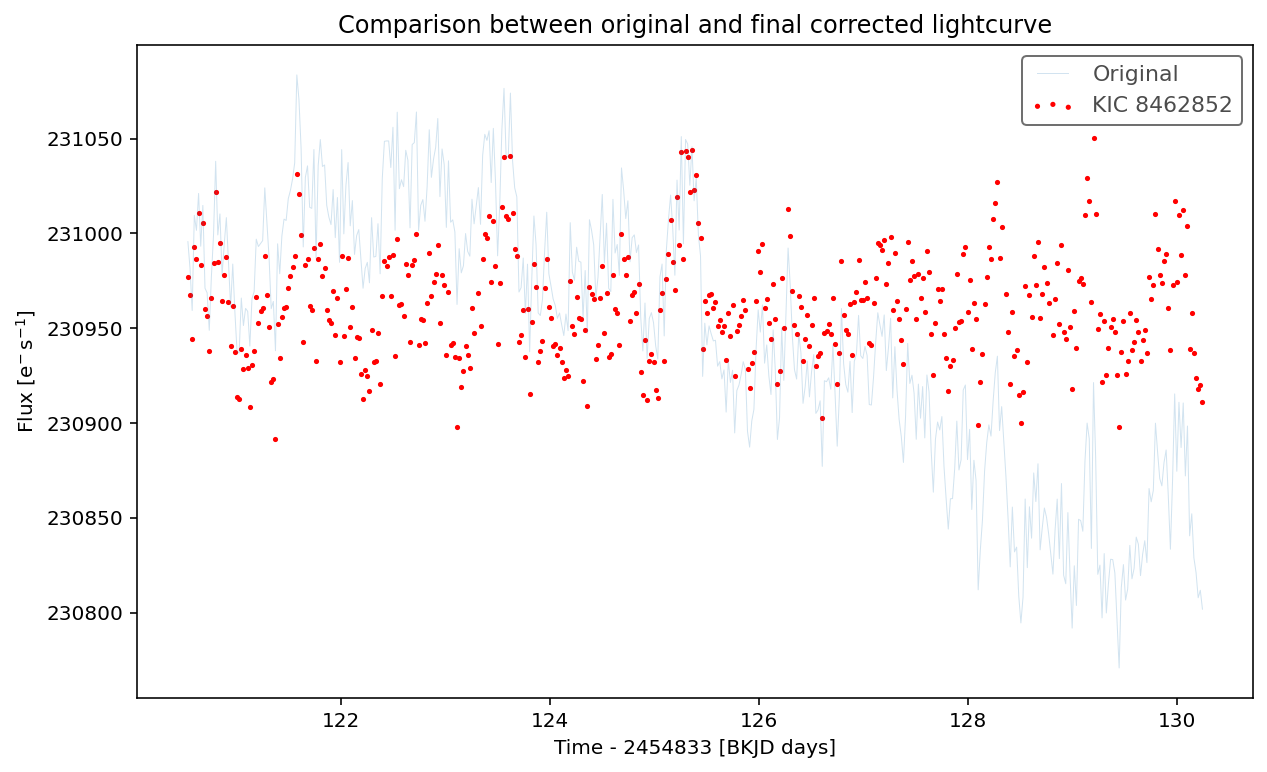

1


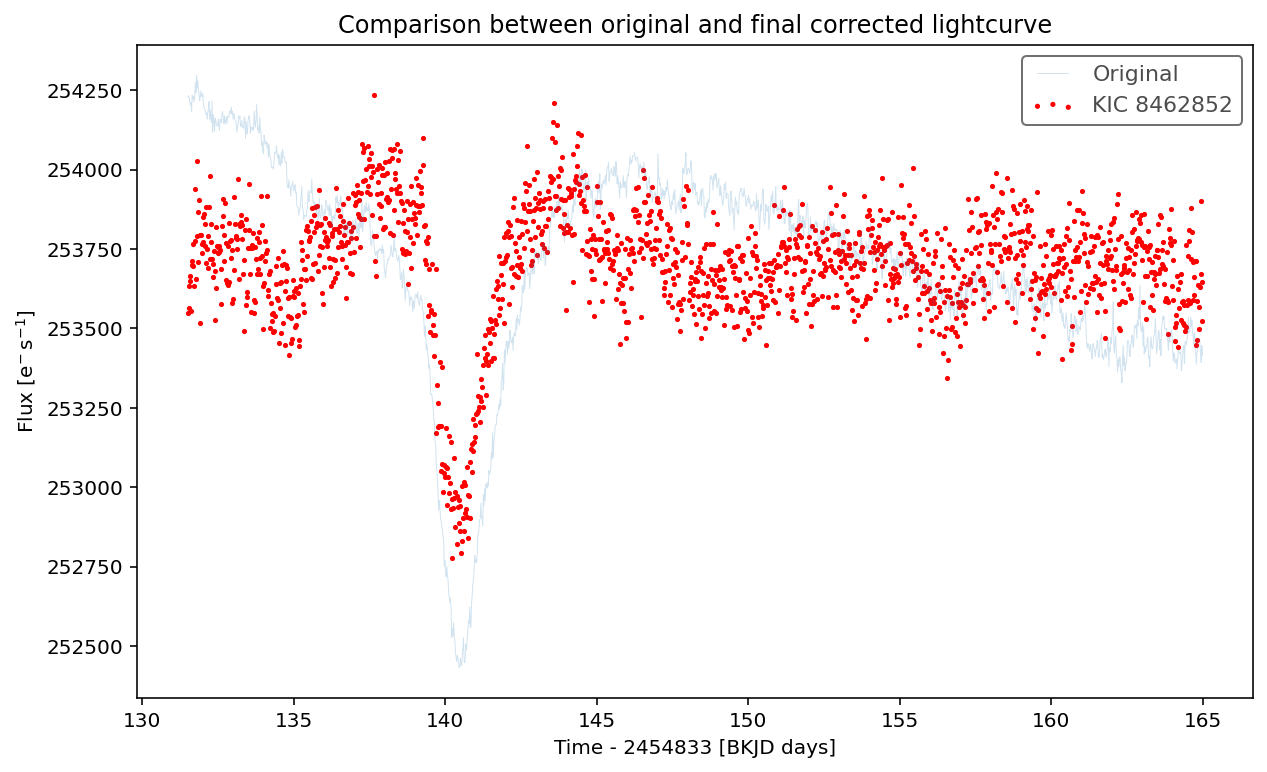

2


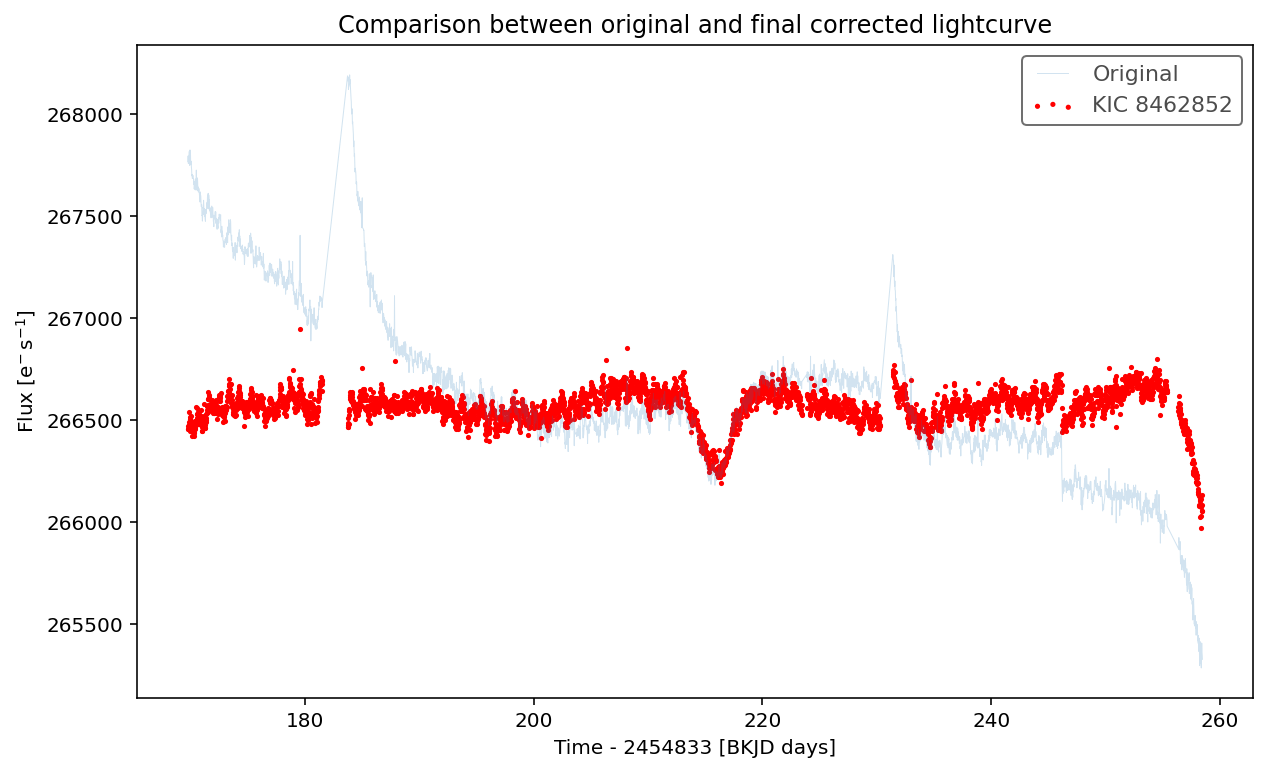

3


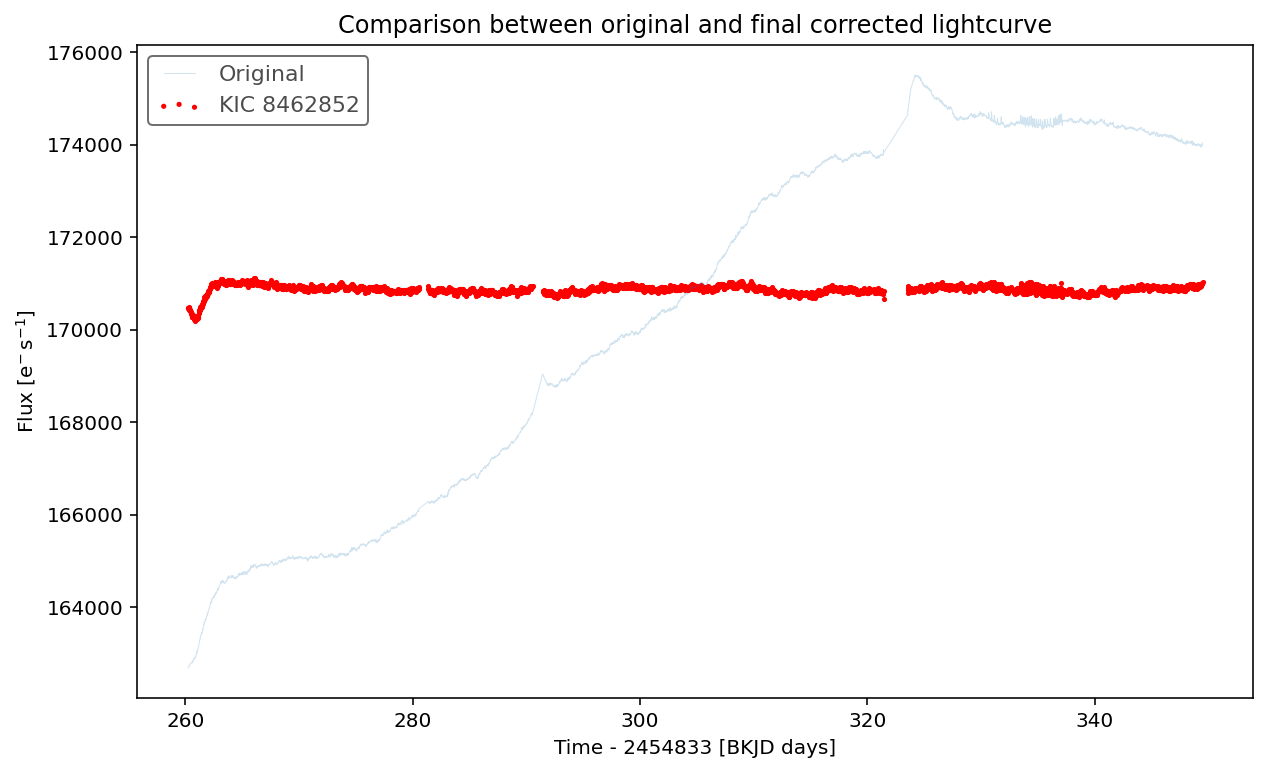

4


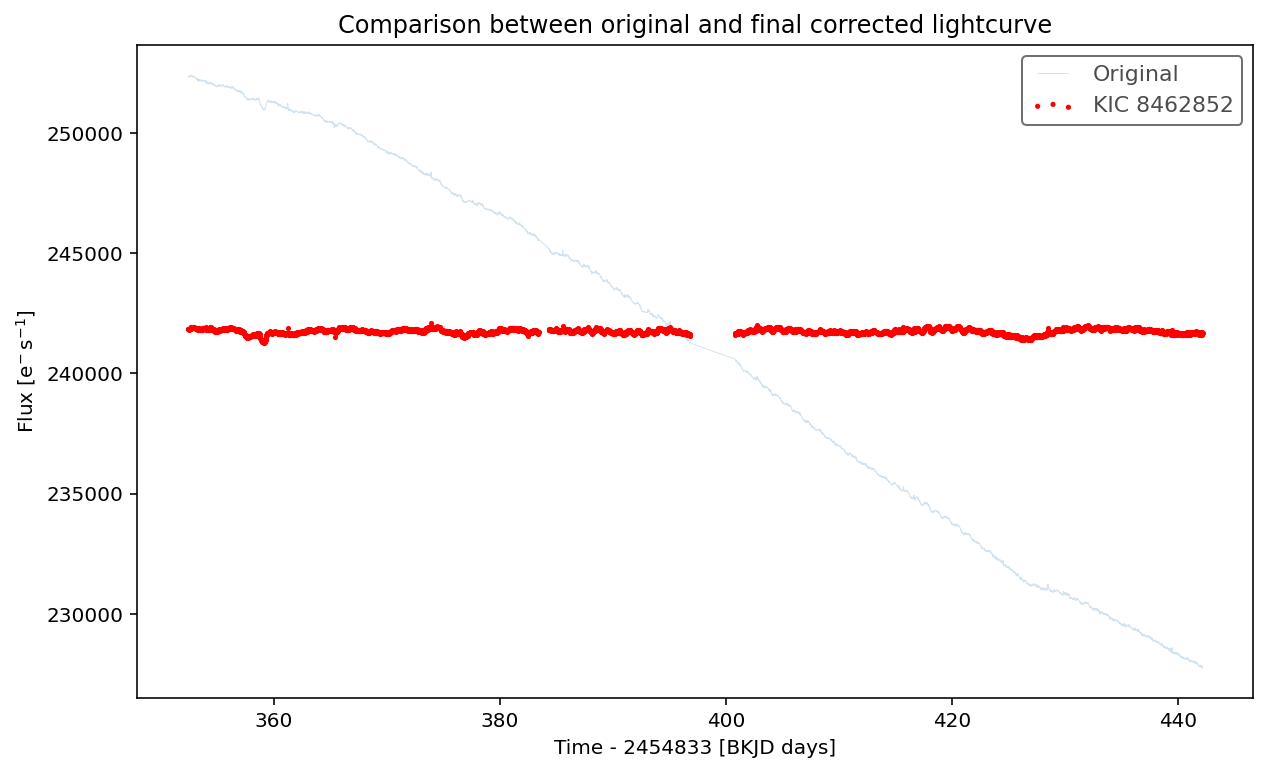

5


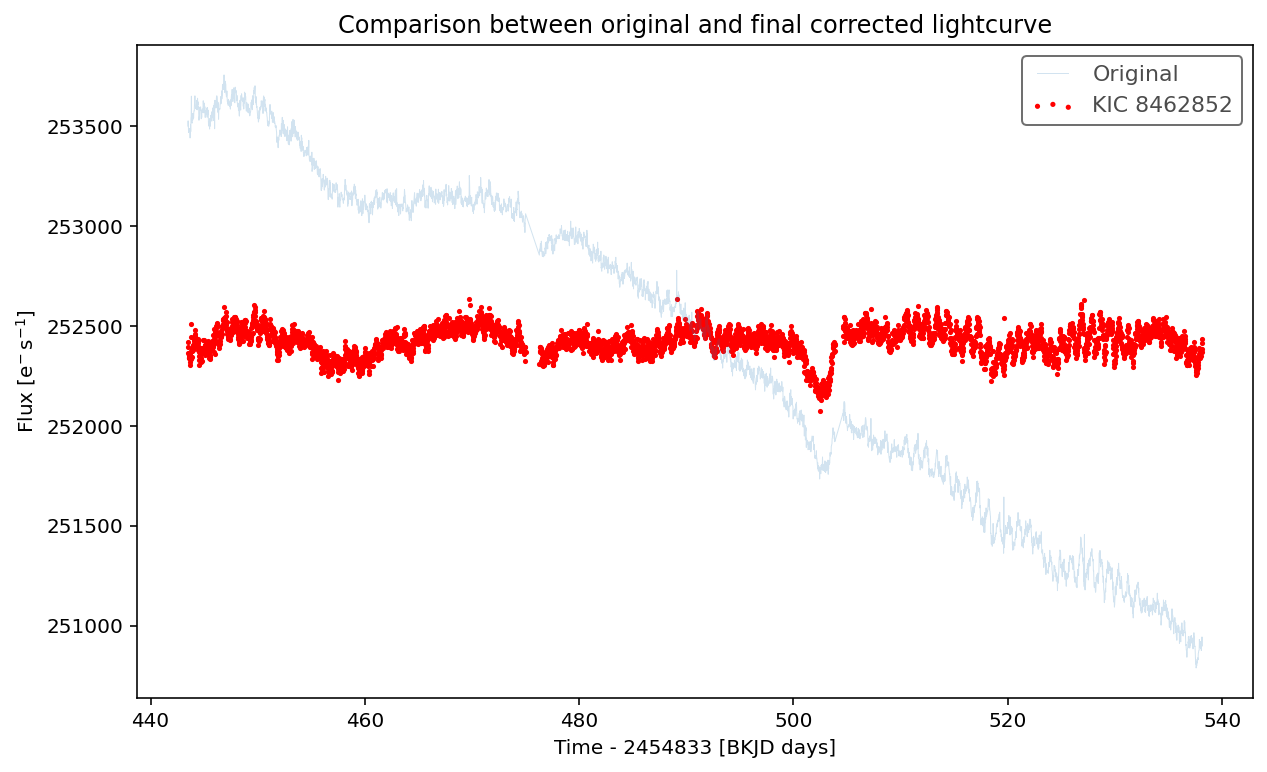

6


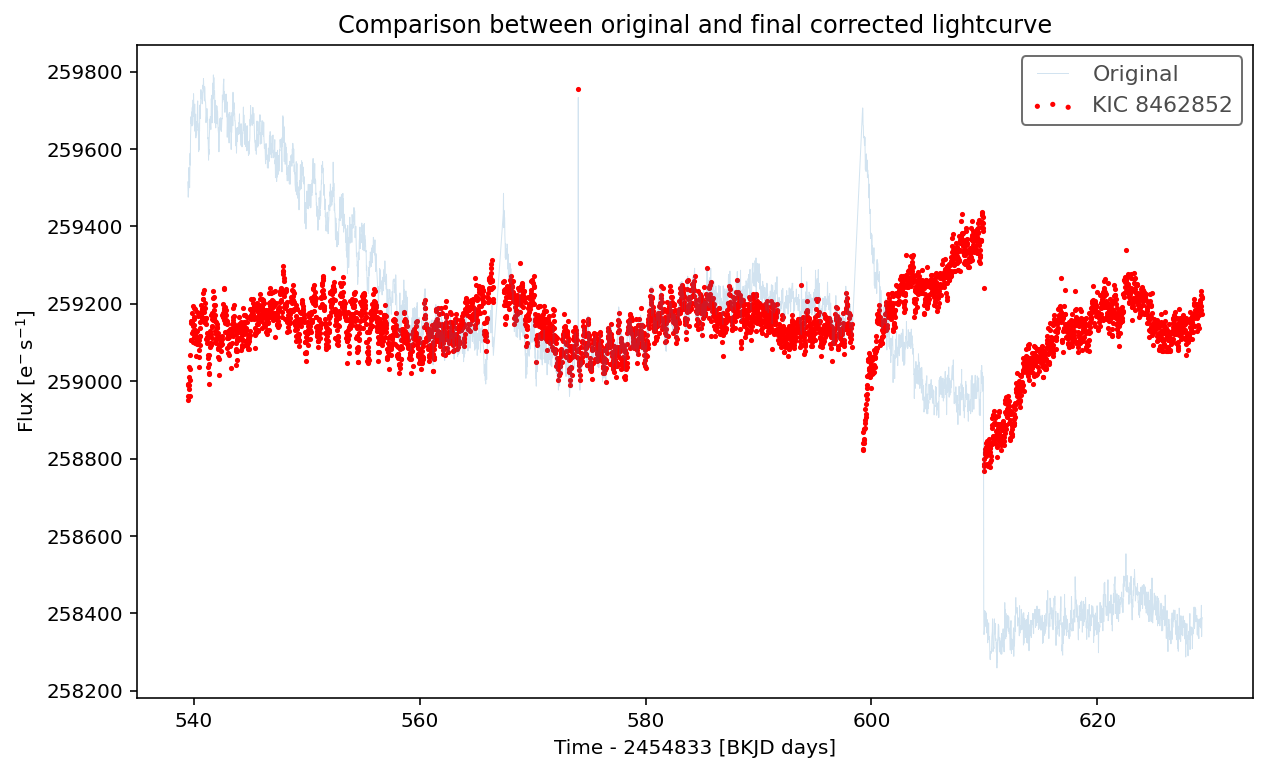

7


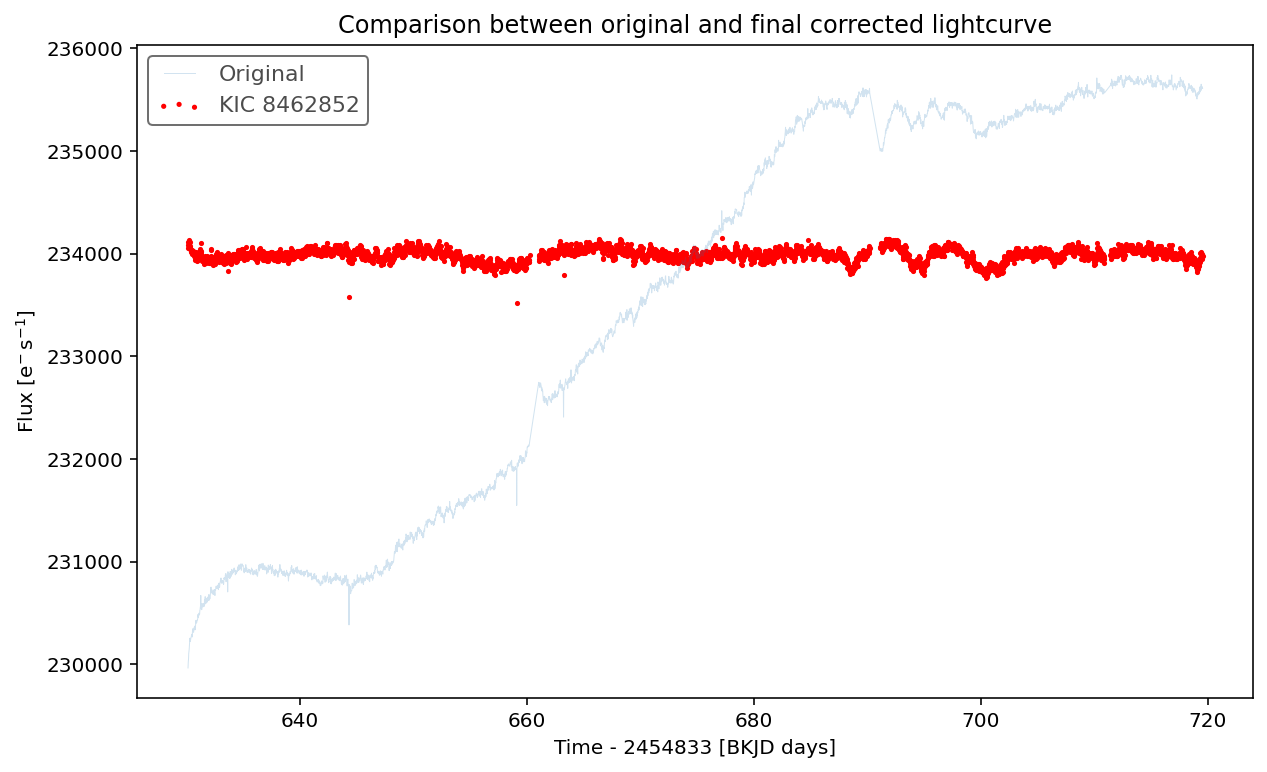

8


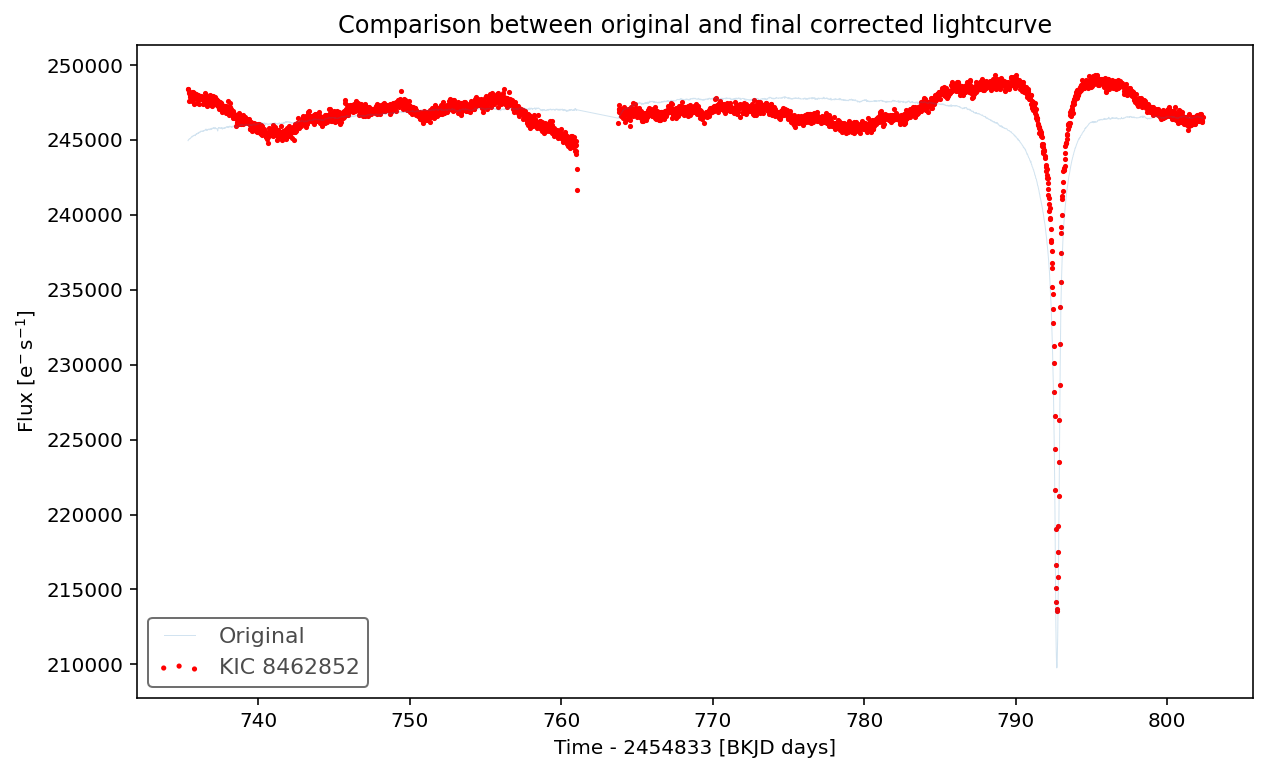

9


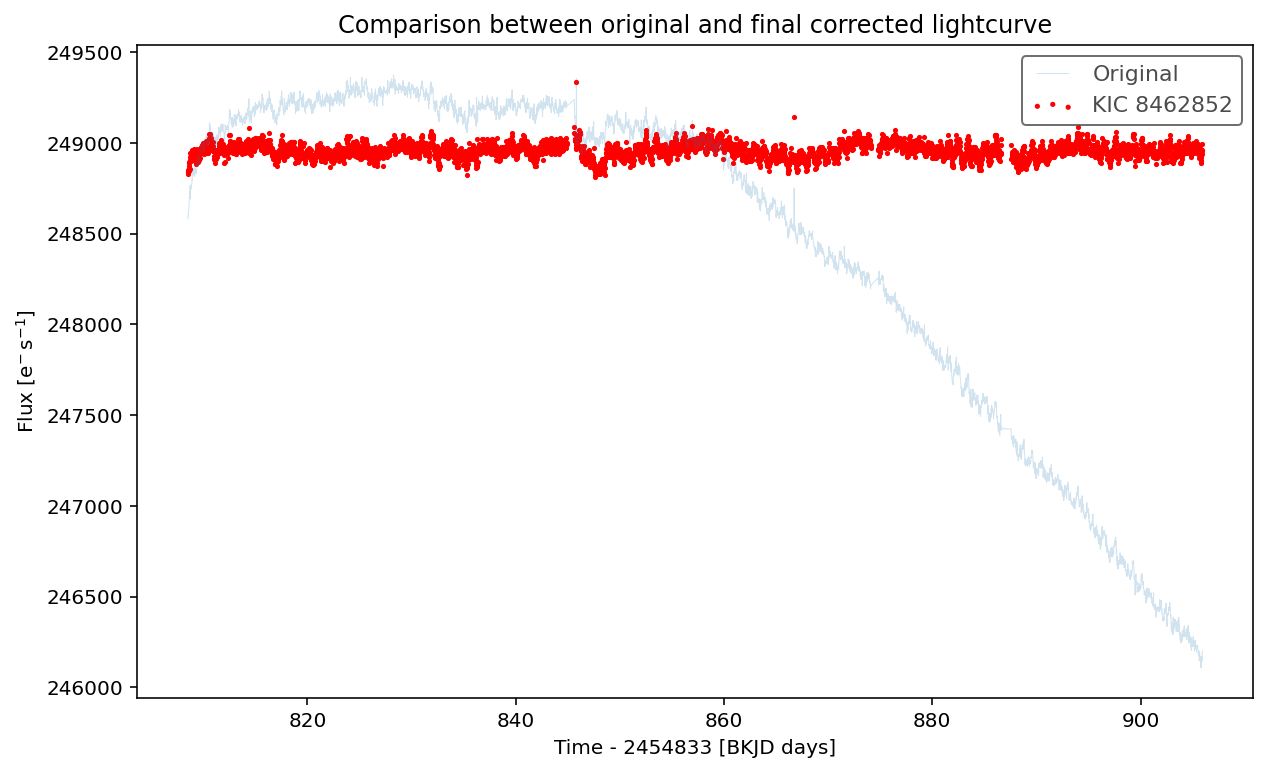

10


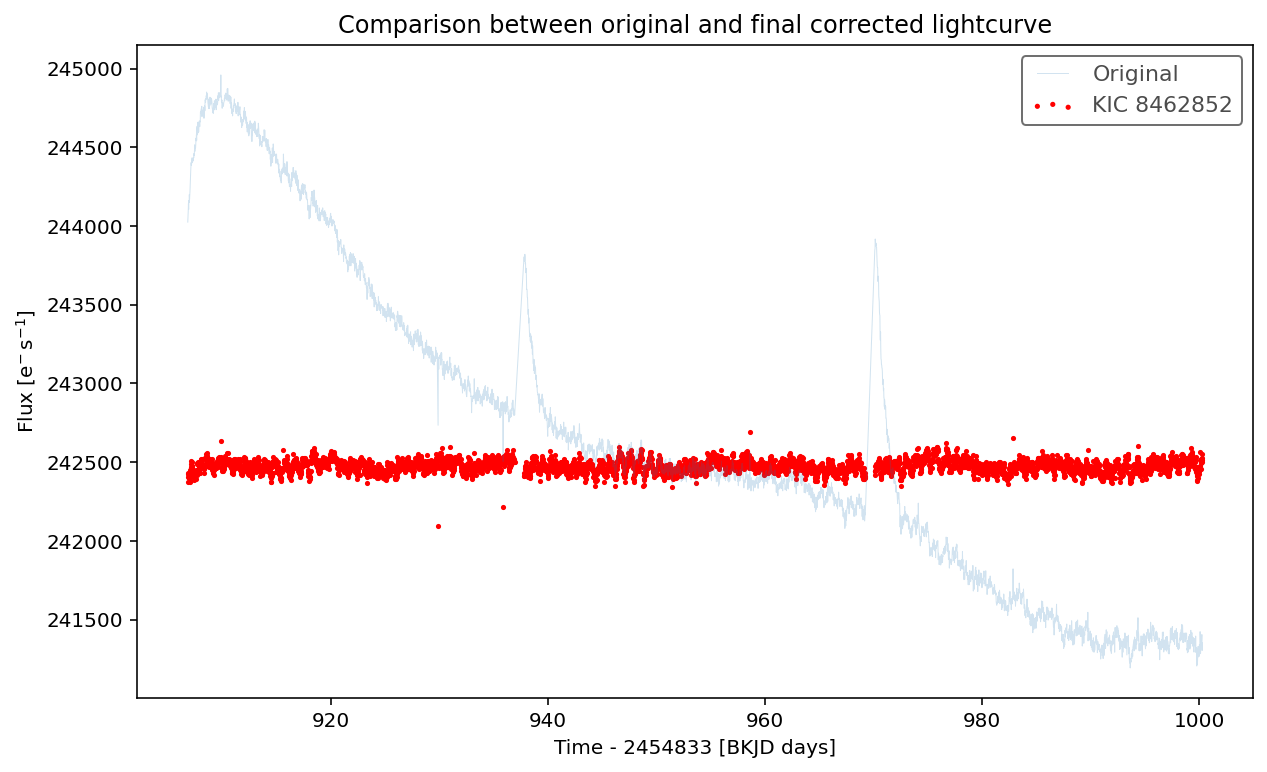

11


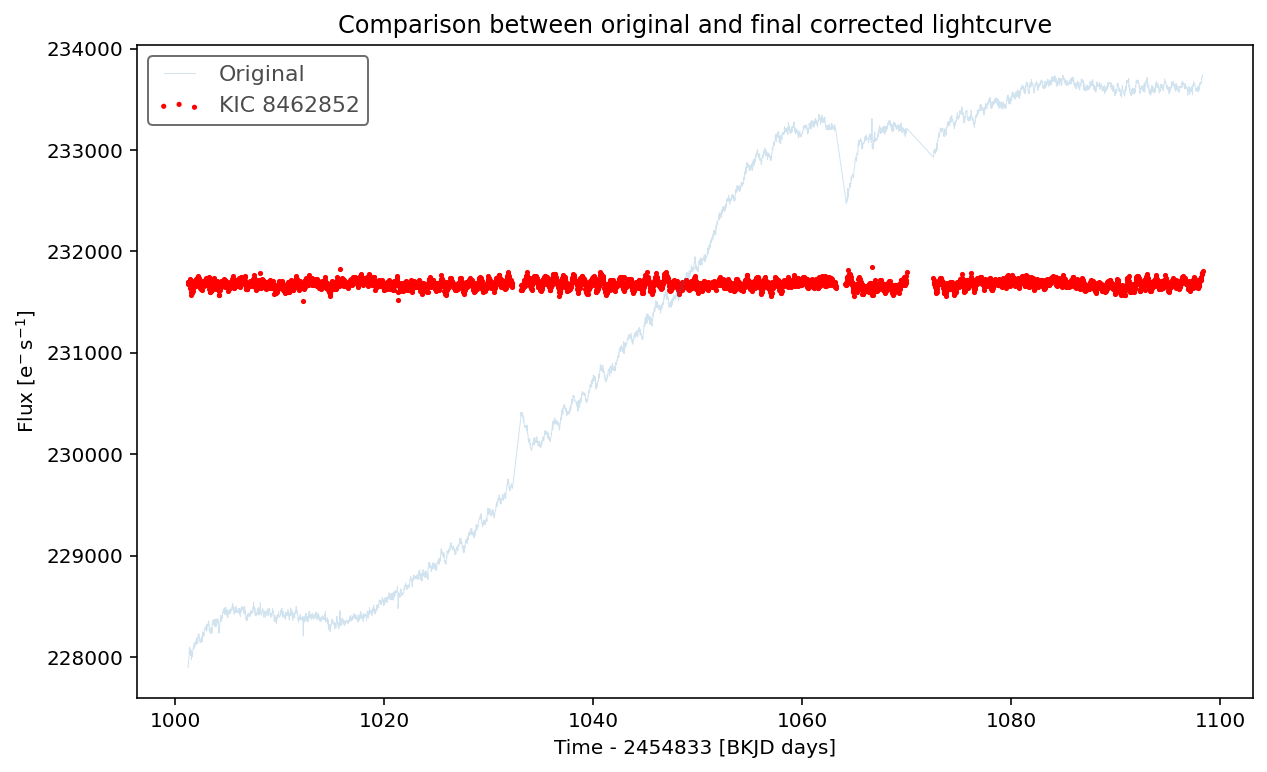

12


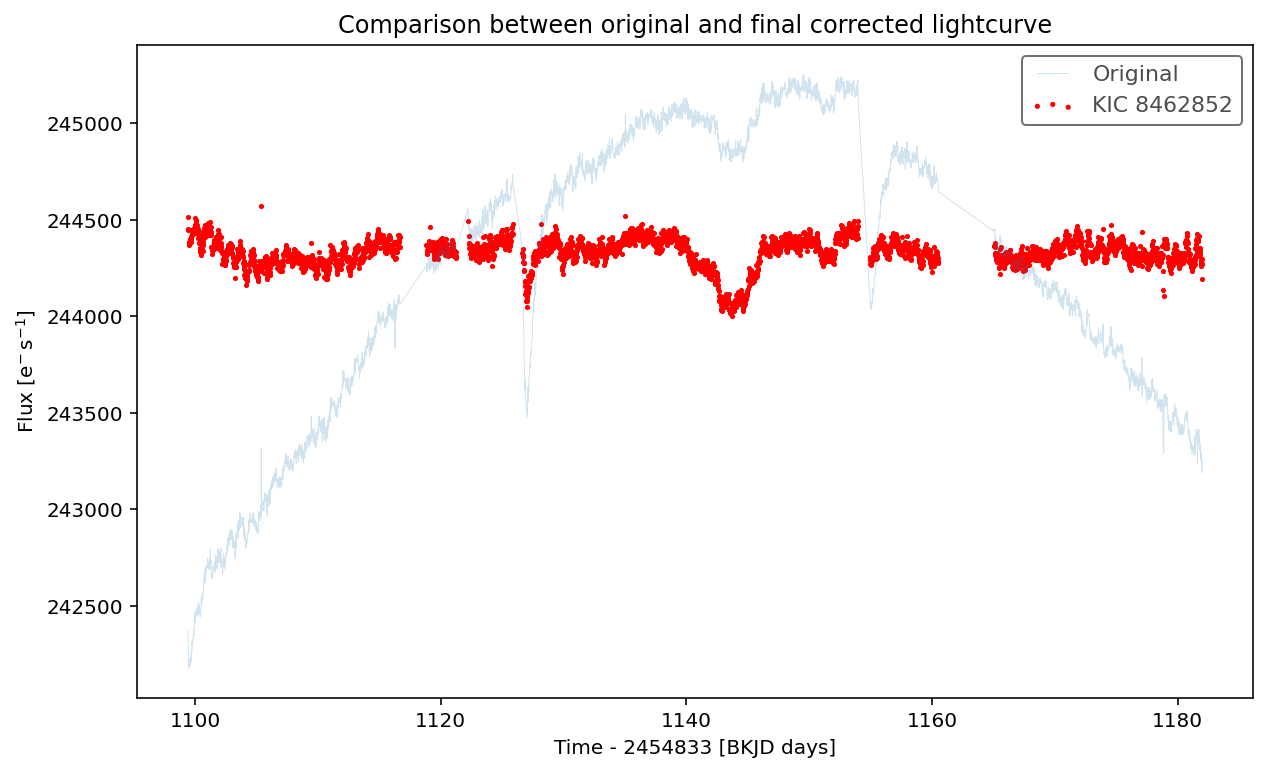

13


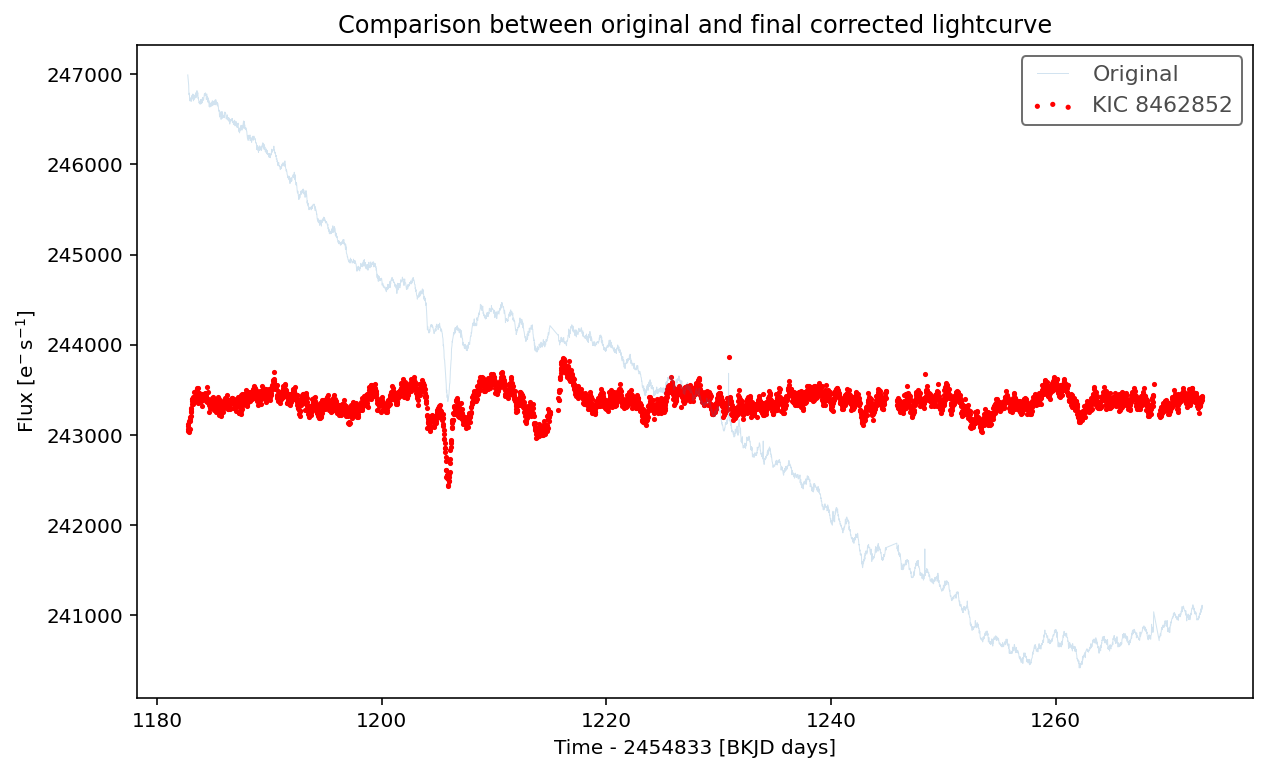

14


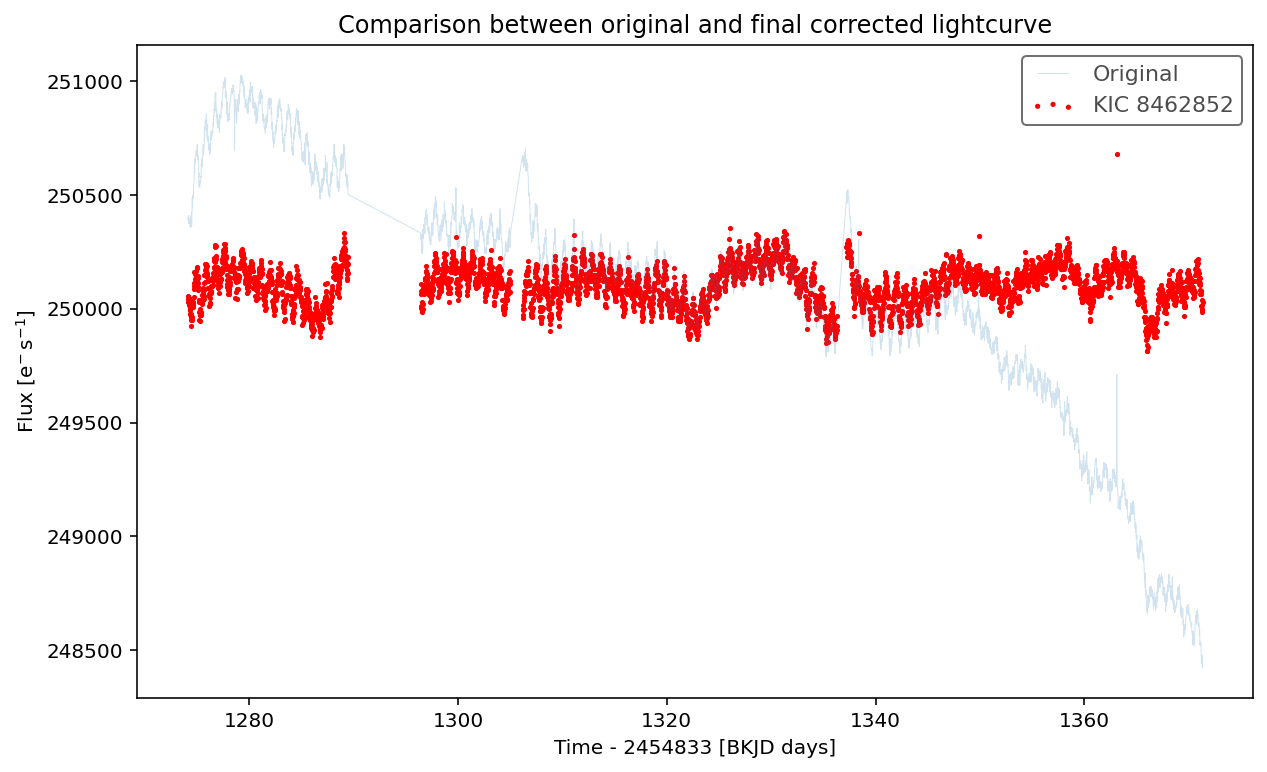

15


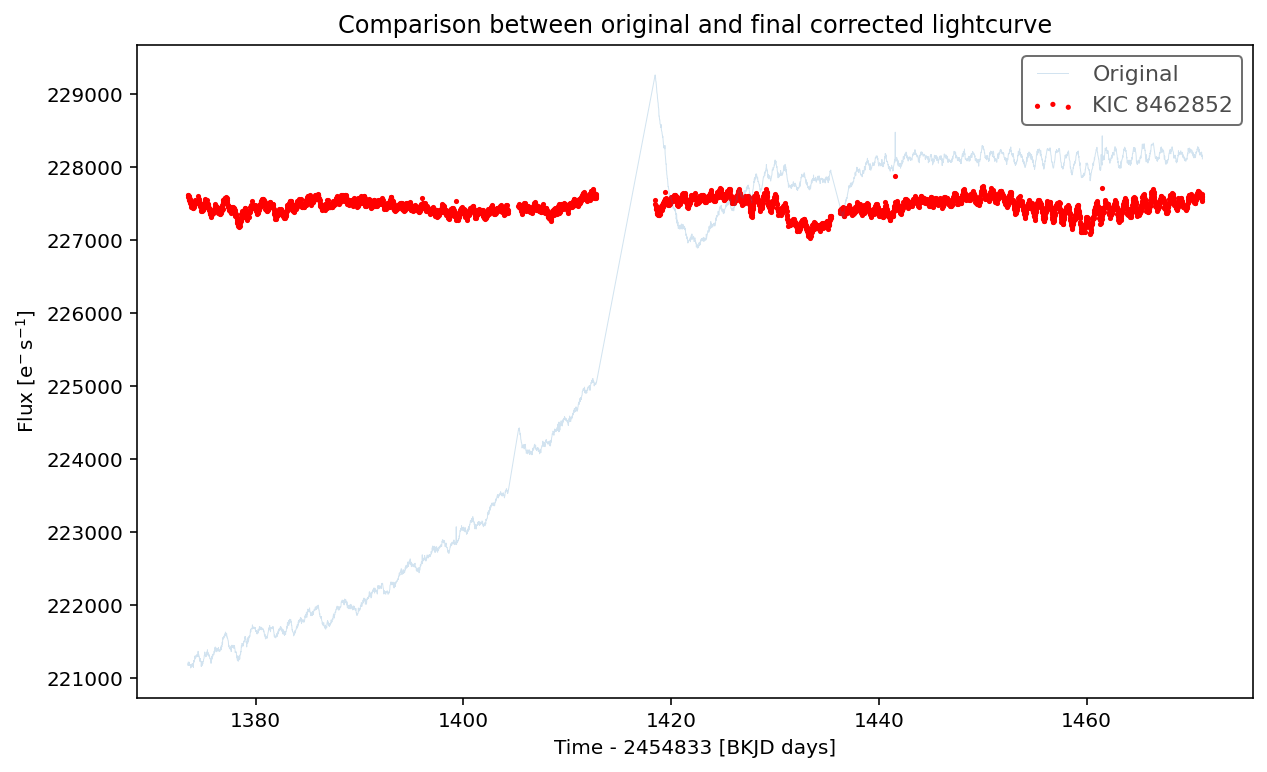

16


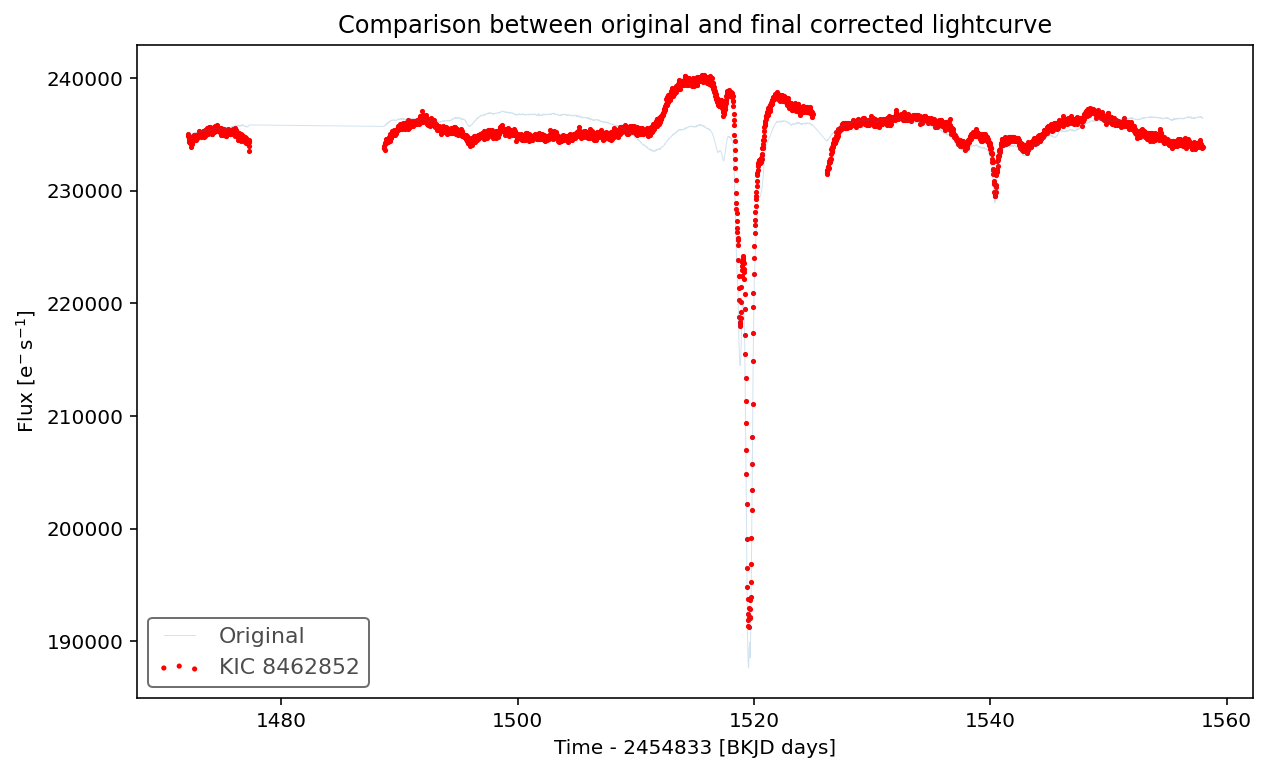

17


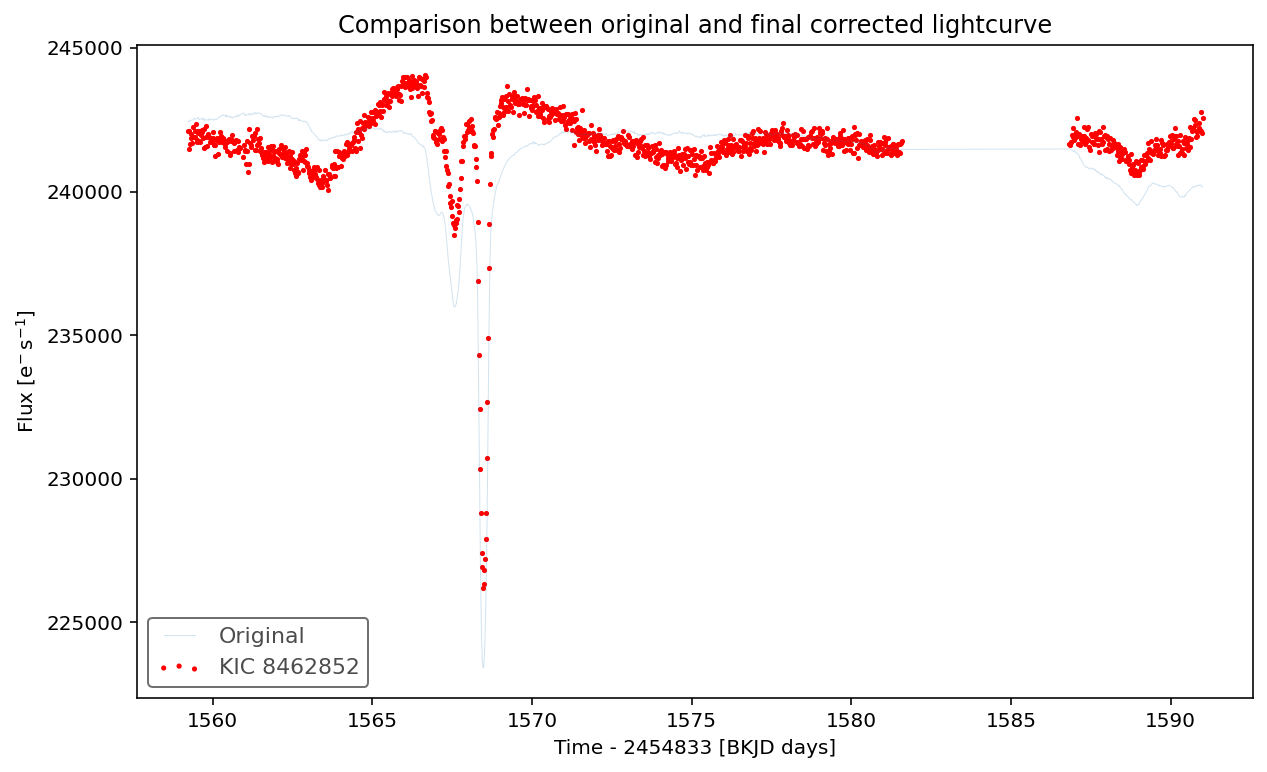

In [89]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9)]
# Perform the correction



for i in range(len(lcs)):
    print(i)
    
    cbvCorrector[i].correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)

    #cbvCorrector[i].correct(cbv_type=cbv_type, cbv_indices=cbv_indices);
    #cbvCorrector[i].diagnose();
    #cbvCorrector[i].goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

    #cbvCorrector[i].correct(cbv_type=cbv_type,
    #                     cbv_indices=cbv_indices, 
    #                     target_over_score=0.9,
    #                     target_under_score=0.5)
    #cbvCorrector[i].diagnose();
    #cbvCorrector[i].goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);
    
    # Fit to the Multi-Scale Band 2 CBVs with ElasticNet to add in a L1-Norm (Lasso) term
    cbvCorrector[i].correct_elasticnet(cbv_type=['SingleScale'], cbv_indices=[np.arange(1,9)], alpha=1.0e-7, l1_ratio=0.5)
    #ax = cbvCorrector[i].diagnose()
    #ax[0].set_title('Result of First Correction to SingleScale.2 CBVs');

    # Plot the final correction
    _, ax = plt.subplots(1, figsize=(10, 6))
    cbvCorrector[i].lc.plot(ax=ax, normalize=False, alpha=0.2, label='Original')
    cbvCorrector[i].corrected_lc.scatter(normalize=False, c='r', marker='.',
                                                s=10, ax=ax)
    ax.set_title('Comparison between original and final corrected lightcurve');
    
    ax.plot()
    plt.show()

In [90]:
lcs_final = LightCurveCollection([cbvCorrector[i].corrected_lc for i in range(len(lcs))])
lc_final = lcs_final.stitch()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

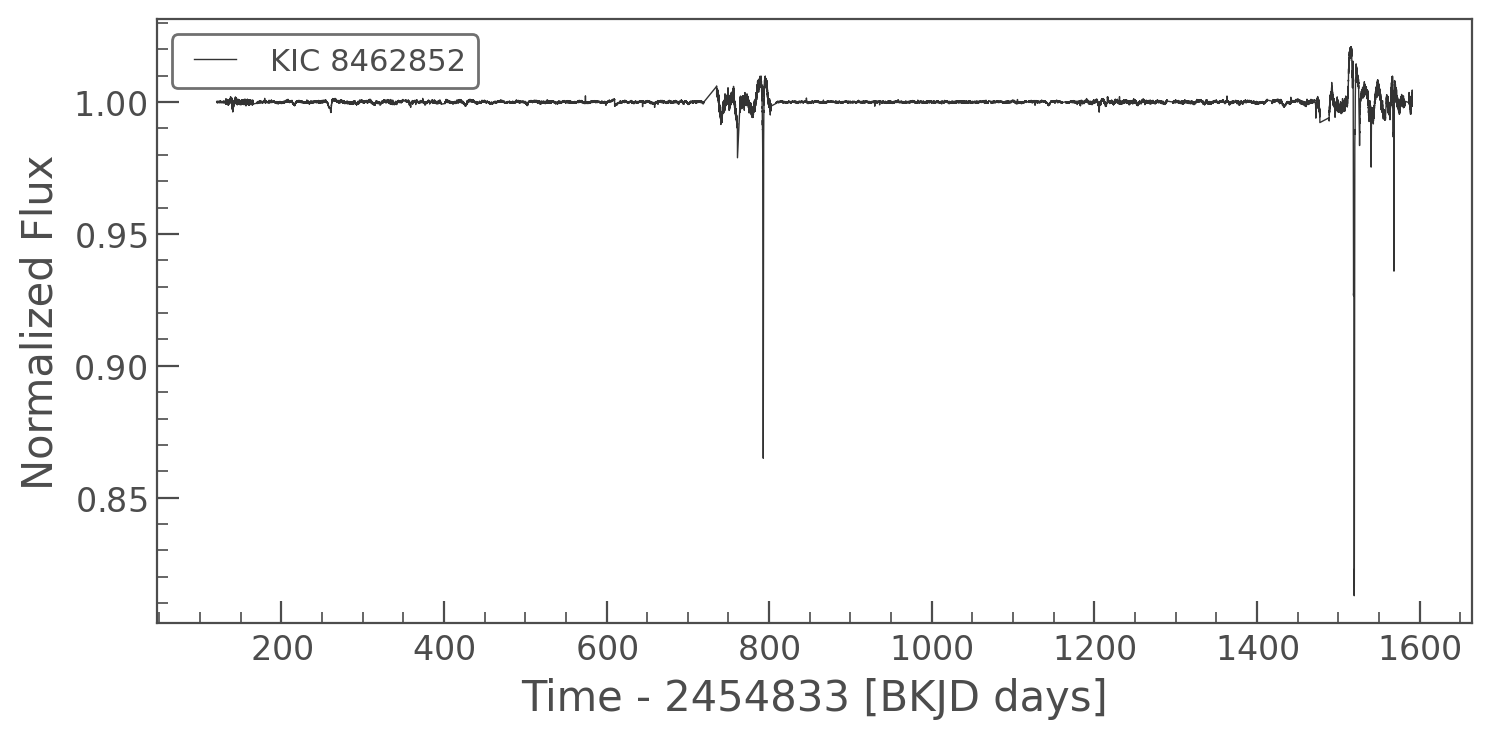

In [91]:
lc_final.plot()

#plt.xlim(1300,1600)

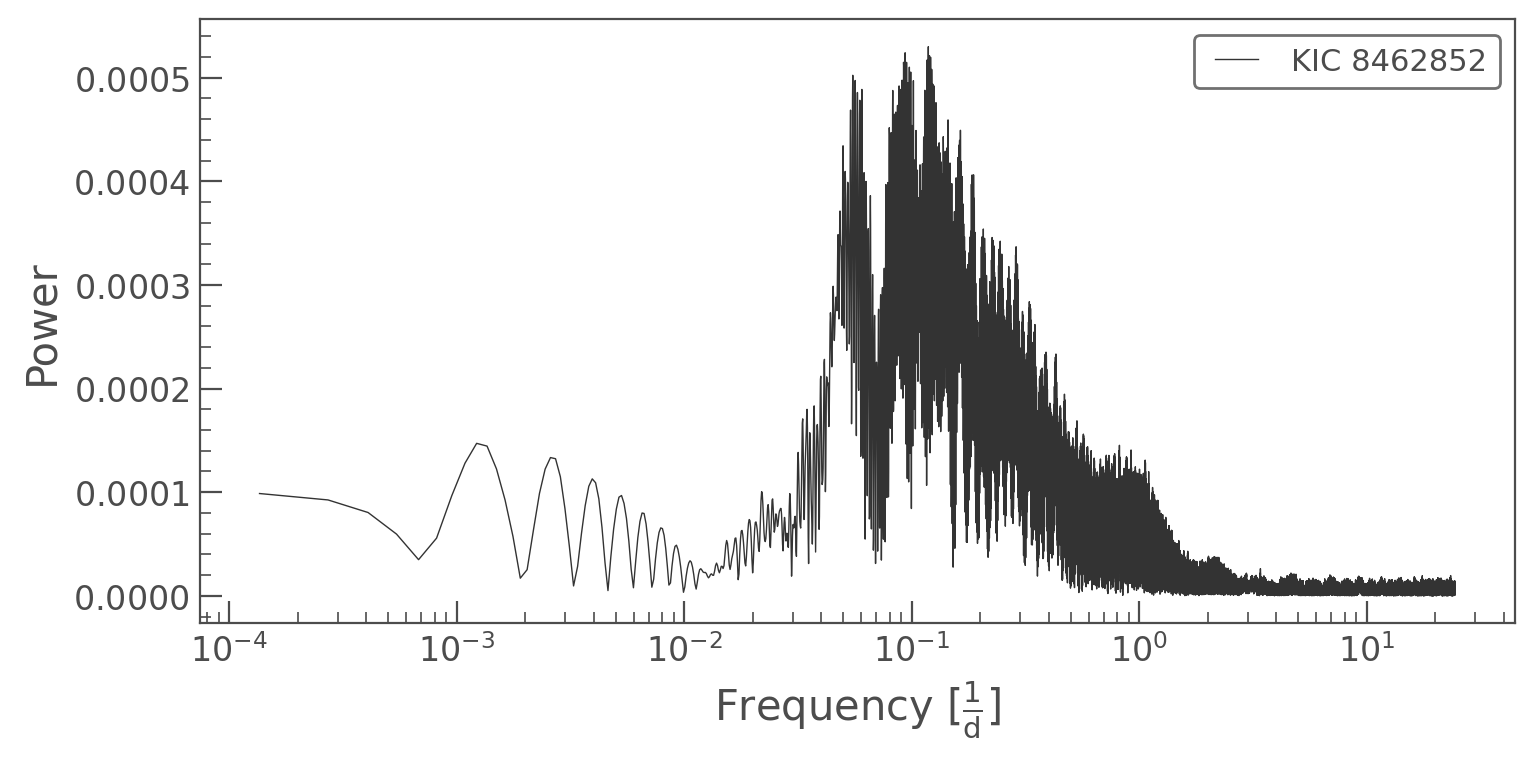

8.450933006900527 d


In [92]:
pg = lc_final.to_periodogram()
ax = pg.plot()
ax.set_xscale('log')
plt.show()

print(pg.period_at_max_power)